### Gradient Descent

&nbsp;

Gradient descent is machine learning 101. Gradient refers to the derivative of a matrix in linear algebra. The basics of GD is similar to Ordinary Least Square. They are using the same approach to minimize the mean square error. The only difference is that OLS gets the global optima via inverse while GD gets the local optima via iteration. Theoretically, the computation of inverse matrix would be more costly than the convergence of iteration in a really large matrix. 

Assuming we have an equation $y=x\theta+\epsilon$, where $y,\epsilon \in \mathbb{R}^m$, $x \in \mathbb{R}^{m \times n}$ and $\theta \in \mathbb{R}^{n}$.

* OLS solves the problem by minimizing $J(\theta)=(y-x\theta)^T(y-x\theta)$ with respect to $\theta$. By setting the partial derivative $\frac{\partial J(\theta)}{\partial \theta}=0$, we shall obtain $\theta=(x^Tx)^{-1}x^Ty$. 

* GD solves the problem by iterations of $\theta:=\theta-\alpha\frac{\partial J(\theta)}{\partial \theta}$, where $\alpha$ denotes the learning rate and $\frac{\partial J(\theta)}{\partial \theta}=x^T(x\theta-y)$.

So when do we stop the iteration of GD? This is where data science becomes state of art. This is no definite way. We have to preset the threshold $\tau$, and when the threshold $\tau$ is beached, we declare the algorithm has converged. The threshold $\tau$ could be the percentage/absolute change of the coefficients or objective functions or sum of squared errors from the last iteration. The optimal $\tau$ should be small enough so we get a more accurate result but not too small to drag down the performance. And hyperparameter $\alpha$ is also crucial to the success of the algorithm. If $\alpha$ is too large, we would oscillate around the optima without convergence. On the contrary, a really small $\alpha$ takes forever to reach the optima.

The application of GD ranges from Independent Component Analysis to Neural Networks. As long as we can solve the objective function in closed form (otherwise we need Expectation Maximization), we can always apply GD instead of OLS or Maximum Logarithm Likelihood to outperform the computation of the inverse matrix. 

In [111]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [112]:
# Load the California housing dataset
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)
print(f"The dimension of X is {X.shape[0]} by {X.shape[1]} wihtout adding theta_0.")

The dimension of X is 20640 by 8 wihtout adding theta_0.


In [113]:
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [114]:
# Add a bias term (for theta_0)
X = np.c_[np.ones(X.shape[0]), X]

## Batch Gradient Descent Algorithm

In [115]:
# Batch Gradient Descent
# alpha denotes learning rate 
# alpha usually takes 0.05,0.03,0.01,0.005,0.003,0.001 etc
# tau denotes the threshold of convergence
# tau usually take 0.01,0.001,0.0001,0.00001
# we should try different hyper parameters
# we need to balance the tradeoff between precision and performance
def bgd(X, Y, tau=0.001, alpha=0.00001, max_itr=1000, theta_init=[], diagnosis=True, plot_residuals=False):
    # initialize
    counter = 0

    # theta denotes coefficients
    # initialize theta
    if len(theta_init) > 0:
        theta = theta_init
    else:
        theta = np.zeros((X.shape[1], 1))    # we usually start with theta = 0

    # residuals or you can call it objective function
    epsilons = []

    # collect thetas for viz
    thetas = [theta.copy()]

    # iterate through the entire dataset
    while counter < max_itr:
        x = X.copy()
        y = Y.copy()

        # gradient descent
        y_estimated = x @ theta      # this is the hypothesis function, which we assume the model is Y=X*Theta
        epsilon = y_estimated - y
        gradient = x.T @ epsilon
        theta -= alpha * gradient

        # tracking
        counter += 1
        epsilons.append(np.mean(epsilon**2))
        thetas.append(theta.copy())

        # Early stopping based on gradient magnitude or parameter magnitude
        if np.linalg.norm(gradient) > 1e5 or np.linalg.norm(theta) > 1e5:
            if diagnosis:
                print(f'Stopping early due to divergence.')
            break

        # convergence
        if len(epsilons) > 1 and abs(epsilons[-1] - epsilons[-2]) < tau:
            if diagnosis:
                print(f'Converged after {counter} iterations.')
            break


    if plot_residuals:
        # Plotting the residuals
        plt.scatter(y_estimated, epsilon, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()

    if diagnosis and not (len(epsilons) > 1 and abs(epsilons[-1] - epsilons[-2]) < tau):
        print(f'Not converged.')
        
    return theta, thetas, epsilons

Converged after 47 iterations.


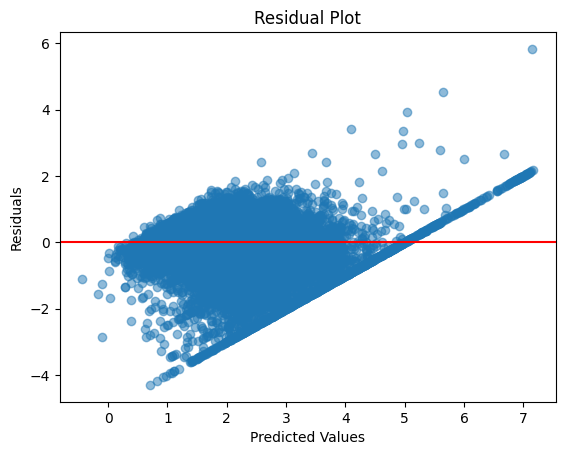

[ 2.06851864  0.81588297  0.17792656 -0.12381531  0.13749101  0.01706369
 -0.04400363 -0.47969283 -0.44313596]


In [116]:
# Use the bgd function
theta_bgd, thetas, epsilons = bgd(X, y, plot_residuals=True)
print(theta_bgd.ravel())

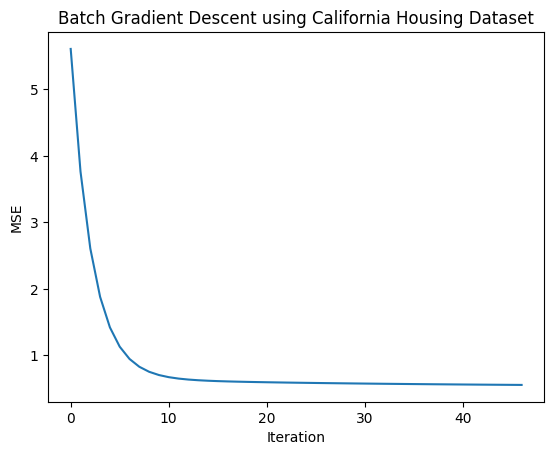

In [117]:
# Plot the MSE
plt.plot(epsilons)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Batch Gradient Descent using California Housing Dataset')
plt.show()


# We first load the California Housing dataset and standardize the features.
# We then initialize the model parameters and set the learning rate and number of iterations.
# In each iteration of the Batch Gradient Descent, we compute the gradient of the cost function with respect to the parameters and update the parameters.
# We also keep track of the cost (MSE) at each iteration and plot it at the end.
# The decreasing curve of the MSE in the plot indicates that the Batch Gradient Descent is working correctly and optimizing the parameters of the linear regression model.


## Stochastic Gradient Descent Algorithm

Stochastic Gradient Descent is an alternative algorithm that takes less computing power than Batch Gradient Descent when the data is large. In other words, it is designed to boost the performance of GD. SGD takes consideration of the error from a random sample at each iteration which greatly reduces the computation burden.

The core difference between BGD and SGD: 
* BGD repeats {$\theta:=\theta-\alpha\cdot x^T(x\theta-y)$} <br>
&emsp;&emsp;&emsp;&emsp; &emsp; &nbsp; for all j = 0, 1, ..., n

* SGD repeats {for i = 1, 2, ..., m <br>
&emsp;&emsp;&emsp;&emsp; &emsp; &emsp;&emsp;{$\theta:=\theta-\alpha\cdot x^T(x\theta-y)$} <br>
&emsp;&emsp;&emsp;&emsp; &emsp; &nbsp;} for all j = 0, 1, ..., n

* BGD does not truly converge on non-convex functions. It will just keep going around the global minimum

where m represents the training example (# of rows) and n represents the dimension (# of features)

In [125]:
#stochastic gradient descent
#the only difference from bgd is the bootstrapping
#bgd iterates through the entire dataset at each step
#sgd randomly picks a set of data and runs gradient descent
#until it reaches convergence or maximum number of iterations
def sgd(X,Y,tau=0.001,alpha=0.01,max_itr=1000,
        theta_init=[],diagnosis=True, plot_residuals = False, plot_mse_interval = 50):

    #initialize
    counter=0

    #theta denotes coefficients
    #initialize theta
    if len(theta_init)>0:
        theta=theta_init
    else:
        theta=np.zeros((X.shape[1],1))

    #residuals or you can call it objective function
    epsilons=[]
    
    # List to store predictions at intervals
    all_predictions = []

    #iterate through the dataset
    while counter<max_itr:
        
        #bootstrapping
        i=np.random.randint(X.shape[0])        
        x=X[i].reshape(1,-1)
        y=Y[i].reshape(-1,1)

        #gradient descent
        y_estimated=x@theta
        epsilon=y_estimated-y
        gradient=x.T@epsilon
        theta-=alpha*gradient

        #tracking
        counter+=1
        epsilons.append(epsilon.ravel()[0])
        thetas.append(theta.copy())

        # store predictions over entire dataset at intervals
        if counter % plot_mse_interval == 0:
            y_all_estimated = X @ theta
            all_predictions.append(y_all_estimated)

        #convergence
        if len(epsilons)>1 and abs(epsilons[-1]-epsilons[-2])<tau:
            if diagnosis:
                print(f'SGD has converged after {counter} iterations.')
                break
        
    if plot_residuals:
        # Plotting the residuals
        y_all_estimated = X @ theta
        epsilon_all = y_all_estimated - Y
        plt.scatter(y_all_estimated, epsilon_all, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()
                
    if diagnosis and counter == max_itr:
        print(f'SGD has not converged.')
        
    return theta,epsilons, all_predictions

SGD has converged after 213 iterations.


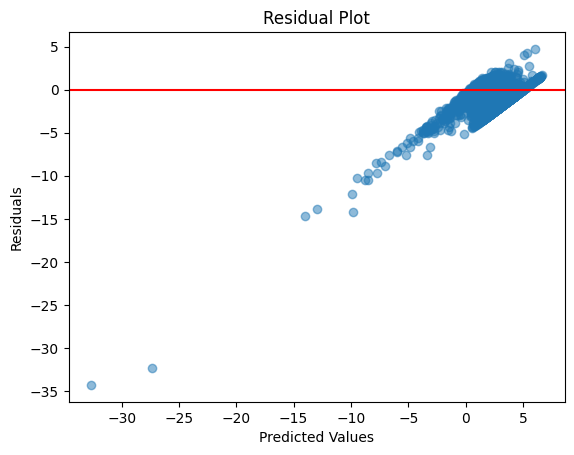

[ 1.83032947  0.76799483  0.02742439 -0.14054417 -0.39213236 -0.06112213
 -0.05624339 -0.27685204 -0.06732015]


In [126]:
# Use the sgd function
theta_sgd, epsilons, all_predictions_sgd= sgd(X, y, plot_residuals=True)
print(theta_sgd.ravel())

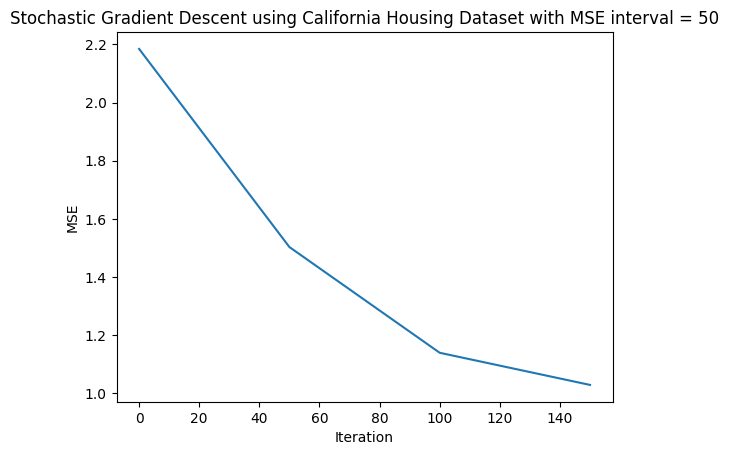

In [127]:
# Compute MSE for all predictions
mse_list = [np.mean((pred - y) ** 2) for pred in all_predictions_sgd]
plot_mse_interval = 50
# Plot the MSE
plt.plot(range(0, len(all_predictions_sgd) * plot_mse_interval, plot_mse_interval), mse_list)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Stochastic Gradient Descent using California Housing Dataset with MSE interval = 50')
plt.show()

## Mini-batch Gradient Descent Algorithm

Mini-batch Gradient Descent is a mixture of BGD and SGD. MBGD takes consideration of the error from a subset at each iteration. It attempts to balance the tradeoff between efficiency from SGD and effectiveness from BGD. However, it creates a new hyperparameter for us to tune, batch size. Our learning rate $\alpha$ is required to adapt with the change of batch size.

In [121]:
def mbgd(X,Y,tau=0.001,alpha=0.01,max_itr=1000,
        theta_init=[],batch_size=100,shuffle=False,
         diagnosis=True, plot_residuals = False):

    #initialize
    counter=0

    #theta denotes coefficients
    #initialize theta
    if len(theta_init)>0:
        theta=theta_init
    else:
        theta=np.zeros((X.shape[1],1))

    #residuals or you can call it objective function
    epsilons=[]
    
    #collect thetas for viz
    thetas=[theta.copy()]

    # List to store predictions at intervals
    all_predictions = []
    
    #shuffled subset
    aleatoire=np.random.choice(X.shape[0],batch_size)

    #iterate through the entire dataset
    while counter<max_itr:
        
        #shuffled subset
        if shuffle:
            aleatoire=np.random.choice(X.shape[0],batch_size)
        x=X[aleatoire]
        y=Y[aleatoire]            

        #gradient descent
        y_estimated=x@theta
        epsilon=y_estimated-y
        gradient=x.T@epsilon/x.shape[0]
        theta-=alpha*gradient

        #tracking
        counter+=1
        epsilons.append(epsilon.ravel()[0])
        thetas.append(theta.copy())

        # append predictions for the entire dataset
        all_predictions.append(X @ theta)

        #convergence
        if len(epsilons)>1 and abs(epsilons[-1]-epsilons[-2])<tau:
            if diagnosis:
                print(f'Converged after {counter} iterations.')
                break

    if plot_residuals:
        # Plotting the residuals
        y_all_estimated = X @ theta
        epsilon_all = y_all_estimated - Y
        plt.scatter(y_all_estimated, epsilon_all, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()

    if diagnosis and counter == max_itr:
        print(f'Not converged.')

    return theta, thetas,epsilons, all_predictions

Converged after 319 iterations.


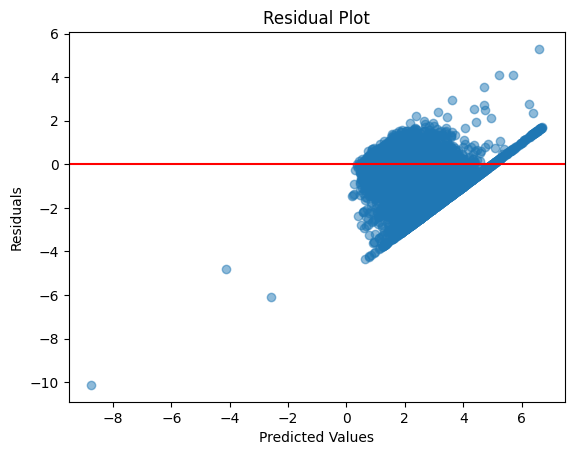

[ 2.00727386e+00  7.12990051e-01  1.81717902e-01  7.16479138e-02
  5.70078067e-04  3.59231162e-02 -1.12645752e-01 -2.62050924e-01
 -2.26136548e-01]


In [122]:
# Use the mbgd function
theta_mbgd, thetas_mbgd, epsilons, all_predictions_mbgd= mbgd(X, y, plot_residuals = True)
print(theta_mbgd.ravel())

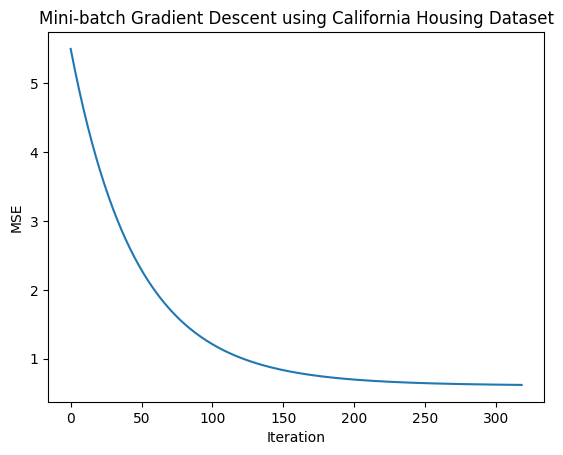

In [123]:
# Compute MSE for all predictions
mse_list = [np.mean((pred - y) ** 2) for pred in all_predictions_mbgd]
# Plot the MSE
plt.plot(mse_list)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Mini-batch Gradient Descent using California Housing Dataset')
plt.show()

In [128]:
# Predictions using BGD
forecast_bgd = X @ theta_bgd
forecast_bgd_rounded = np.round(forecast_bgd)

# Predictions using SGD
forecast_sgd = X @ theta_sgd
forecast_sgd_rounded = np.round(forecast_sgd)

# Predictions using MBGD
forecast_mbgd = X @ theta_mbgd
forecast_mbgd_rounded = np.round(forecast_mbgd)

# Compute "accuracy" for BGD
accuracy_bgd = len(forecast_bgd_rounded[(forecast_bgd_rounded - y)**2 < 0.05]) / len(y)
print('Accuracy of BGD:', accuracy_bgd)

# Compute "accuracy" for SGD
accuracy_sgd = len(forecast_sgd_rounded[(forecast_sgd_rounded - y)**2 < 0.05]) / len(y)
print('Accuracy of SGD:', accuracy_sgd)

# Compute "accuracy" for MBGD
accuracy_mbgd = len(forecast_mbgd_rounded[(forecast_mbgd_rounded - y)**2 < 0.05]) / len(y)
print('Accuracy of MBGD:', accuracy_mbgd)

Accuracy of BGD: 0.25261627906976747
Accuracy of SGD: 0.244234496124031
Accuracy of MBGD: 0.24849806201550387


## Summary

&nbsp;

### Batch Gradient Descent (BGD):

* <strong>Dataset Usage</strong>: Uses the entire dataset to compute the gradient of the cost function for each iteration of the training algorithm.
* <strong>Convergence</strong>: Converges to the global minimum for convex loss functions and to a local minimum for non-convex functions. The path to the minimum is direct and doesn't oscillate.
* <strong>Speed</strong>: Can be slow for large datasets since it processes all samples for each iteration.
* <strong>Memory</strong>: Requires memory to store the entire dataset.
* <strong>Update Frequency</strong>: Model parameters are updated once per epoch (after seeing the entire dataset).

<br>


### Stochastic Gradient Descent (SGD):

* <strong>Dataset Usage</strong>: Uses only one data point (randomly chosen) from the dataset to compute the gradient at each step.
* <strong>Convergence</strong>: Can oscillate and take longer paths to the minimum due to its high variance updates. However, this randomness can help escape local minima in non-convex functions.
* <strong>Speed</strong>: Typically faster than BGD, especially for large datasets, since it updates the model using only one data point at a time.
* <strong>Memory</strong>: Requires memory only for one data point.
* <strong>Update Frequency</strong>: Model parameters are updated after each training example.
* <strong>Learning Rate</strong>: Often requires a decreasing learning rate to converge to the global minimum.

<br>

### Mini-batch Gradient Descent:

* <strong>Dataset Usage</strong>: Uses a mini-batch (a subset) of the dataset to compute the gradient at each step. The size of the mini-batch, often called the "batch size", is a hyperparameter.
* <strong>Convergence</strong>: Convergence path is somewhere between BGD and SGD. It tends to oscillate but less than pure SGD.
* <strong>Speed</strong>: Faster than both BGD (for large datasets) and SGD (especially when leveraging hardware optimizations for matrix operations). It benefits from the advantages of both BGD and SGD.
* <strong>Memory</strong>: Requires memory for the mini-batch.
* <strong>Update Frequency</strong>: Model parameters are updated after each mini-batch.
* <strong>Generalization</strong>: Mini-batch GD can have a regularizing effect and lower generalization error, depending on the mini-batch size.